In [ ]:
!pip install efficientnet

     |████████████████████████████████| 50 kB 3.1 MB/s 


In [ ]:
!pip install livelossplot
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

import inspect
from tqdm import tqdm
#from keras.layers import LSTM

import efficientnet.keras as efn
from google.colab import drive
drive.mount('/gdrive/',force_remount=True)

     |████████████████████████████████| 793 kB 7.3 MB/s 
     |████████████████████████████████| 381 kB 66.1 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.33.0 which is incompatible.


Mounted at /gdrive/


In [ ]:
# Convolutional Neural Network

# Importing the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

In [ ]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "/gdrive/MyDrive/Data Set/model/cnn_VGG16_model.h5"
WEIGHT_FILE="/gdrive/MyDrive/Data Set/model/cnn_VGG16_weight.h5"

# Data
path = "/gdrive/MyDrive/Data Set/MelData/"
training_data_dir = path + "eval" 
validation_data_dir = path + "dev" 
test_data_dir = path + "train" # 12 500

In [ ]:
# Hyperparams
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 20
BATCH_SIZE = 64
TEST_SIZE = 30
num_classes=2

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [ ]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"

# Data
path = "/gdrive/MyDrive/Data Set/MelData/"
training_data_dir = path + "eval" 
validation_data_dir = path + "dev" 
test_data_dir = path + "train" # 12 500

In [ ]:
# Data augmentation
training_data_generator = ImageDataGenerator(rescale = 1./255,
                                            shear_range = 0.2,
                                            zoom_range = 0.2,
                                            horizontal_flip = True,
                                             )
validation_data_generator = ImageDataGenerator(rescale=1./255 )
test_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
# Data preparation
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    shuffle=True,
    batch_size=BATCH_SIZE,
    #color_mode='grayscale',
    class_mode="binary")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    shuffle=True,
    batch_size=BATCH_SIZE,
    #color_mode='grayscale',
    class_mode="binary")

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    shuffle=False,
    batch_size=BATCH_SIZE,
    #color_mode='grayscale',
    class_mode="binary")

Found 13305 images belonging to 2 classes.
Found 1710 images belonging to 2 classes.
Found 3014 images belonging to 2 classes.


spoof=0.55
genuine=5.13

In [ ]:
training_generator.class_indices

{'genuine': 0, 'spoofed': 1}

In [ ]:
class_weight = {0: 5.13,
                1: .55}

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
import numpy as np


In [ ]:
checkpoint=keras.callbacks.ModelCheckpoint(WEIGHT_FILE,save_best_only=True,monitor='val_accuracy',mode='max')
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
base_model= tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling= 'avg',
    classes=1000,
    classifier_activation="softmax",
)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = True
model = tf.keras.models.Sequential()
model.add(base_model)
#model.add(tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss ='binary_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(lr=0.0001))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,780,481
Trainable params: 14,780,481
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
207/207 [==============================] - 4217s 20s/step - loss: 0.2598 - accuracy: 0.9045 - val_loss: 0.8953 - val_accuracy: 0.6364
Epoch 2/20
207/207 [==============================] - 2198s 11s/step - loss: 0.1638 - accuracy: 0.9298 - val_loss: 0.2328 - val_accuracy: 0.9117
Epoch 3/20
207/207 [==============================] - 2176s 11s/step - loss: 0.1183 - accuracy: 0.9505 - val_loss: 0.1341 - val_accuracy: 0.9585
Epoch 4/20
207/207 [==============================] - 2176s 11s/step - loss: 0.0976 - accuracy: 0.9594 - val_loss: 0.6064 - val_accuracy: 0.6965
Epoch 5/20
207/207 [==============================] - 2166s 10s/step - loss: 0.0845 - accuracy: 0.9650 - val_loss: 0.2537 - val_accuracy: 0.9081
Epoch 6/20
207/207 [==============================] - 2213s 11s/step - loss: 0.0819 - accuracy: 0.9671 - val_loss: 0.3106 - val_accuracy: 0.8600
Epoch 7/20
207/207 [==============================] - 2246s 11s/step - loss: 0.0634 - accuracy: 0.9751 - val_loss: 0.1948 - val_ac

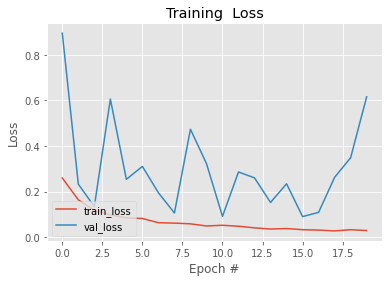

In [ ]:
H = model.fit(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=20,
    validation_data=validation_generator,
    #class_weight= class_weight,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[checkpoint]
)
model.save_weights(MODEL_FILE)
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
#N = stopping.stopped_epoch + 1
plt.plot( H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.xlabel("Epoch #")
plt.title("Training  Loss")
plt.ylabel("Loss")
plt.legend(loc="lower left")

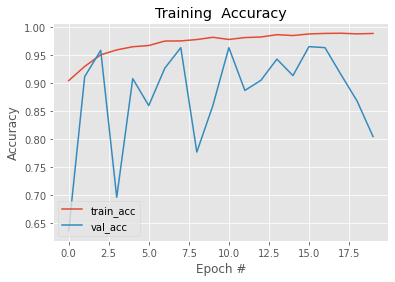

In [ ]:
plt.plot( H.history["accuracy"], label="train_acc")
plt.plot( H.history["val_accuracy"], label="val_acc")
plt.title("Training  Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("/gdrive/MyDrive/Data Set/vgg16training_accuracy.png")

In [ ]:
X_train, y_train = next(training_generator)
X_test, y_test = next(test_generator)


In [ ]:
from pickle import dump
import tensorflow as tf
in_model=tf.keras.models.load_model(WEIGHT_FILE)

in_model.load_weights(WEIGHT_FILE)
predicted_classes = in_model.predict(test_generator).ravel()


In [ ]:
import numpy as np
classes=[]
for i in predicted_classes:
  
  if i>0.5:
    classes.append(1)
  else:
    classes.append(0)
    #classes.append(np.argmax(i))

[Text(0, 0.5, 'Spoof'), Text(0, 1.5, 'Genuine')]

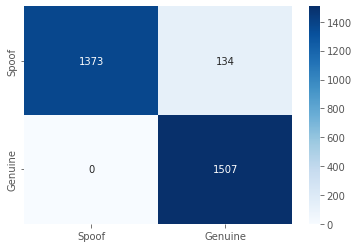

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

ax= plt.subplot()
sns.heatmap(confusion_matrix(test_generator.classes, classes),annot=True,cmap='Blues', fmt='g',ax=ax)

ax.xaxis.set_ticklabels(['Spoof', 'Genuine'])
ax.yaxis.set_ticklabels(['Spoof', 'Genuine'])

In [ ]:
from sklearn.metrics import roc_curve, auc
X_train, y_train = next(training_generator)
X_test, y_test = next(test_generator)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc



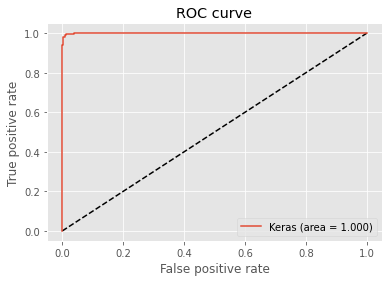

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_generator.classes, predicted_classes)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

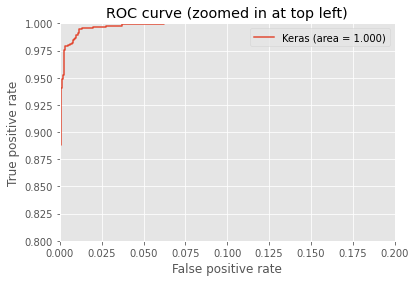

In [ ]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
m_precision = precision_score(test_generator.classes, classes)
print('Precision = '+ str(m_precision))
m_accuracy = accuracy_score(test_generator.classes, classes)
print('Accuracy = '+ str(m_accuracy))
m_recall = recall_score(test_generator.classes, classes)
print('Recall = '+ str(m_recall))

m_f1score= f1_score(test_generator.classes, classes)
print('F1 Score = '+ str(m_f1score))
m_auc = roc_auc_score(test_generator.classes, predicted_classes)
print('AUC = '+ str(m_auc))


Precision = 0.9183424741011579
Accuracy = 0.9555408095554081
Recall = 1.0
F1 Score = 0.957433290978399
AUC = 0.9995689216745214


In [ ]:
fnr = 1 - tpr_keras
eer_threshold = thresholds_keras[np.nanargmin(np.absolute((fnr - fpr_keras)))]
# theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
eer_1 = fpr_keras[np.nanargmin(np.absolute((fnr - fpr_keras)))]
eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr_keras)))]
eer = (eer_1 + eer_2) / 2
print('EER = '+ str(eer))


EER = 0.01061712010617121
